<a href="https://colab.research.google.com/github/UrsachiGabriela/PGPU_proiect/blob/main/Introduction_to_CUDA_%2B_profiling_using_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PGPU - proiect


# Generare graf

In [1]:
%%writefile graph_generator.cpp

#include <iostream>
#include <vector>
#include <fstream>
#include <cstdlib>
#include <ctime>
#include <algorithm>

using namespace std;

vector<vector<int>> generateRandomGraph(int numNodes, int numEdges) {
    vector<vector<int>> graph(numNodes);
    srand(time(0));

    for (int i = 0; i < numEdges; ++i) {
        int u = rand() % numNodes;
        int v = rand() % numNodes;

        while (u == v || find(graph[u].begin(), graph[u].end(), v) != graph[u].end()) {
            u = rand() % numNodes;
            v = rand() % numNodes;
        }
        graph[u].push_back(v);
        graph[v].push_back(u);
    }

    return graph;
}

void writeGraphToFile(const string& filename, const vector<vector<int>>& graph) {
    ofstream outputFile(filename);
    if (!outputFile) {
        cerr << "Eroare la deschiderea fisierului pentru scriere!" << endl;
        return;
    }

    for (const auto& neighbors : graph) {
        for (size_t i = 0; i < neighbors.size(); ++i) {
            outputFile << neighbors[i];
            if (i != neighbors.size() - 1) {
                outputFile << " ";
            }
        }
        outputFile << endl;
    }

    outputFile.close();
}

int main() {
    int numNodes = 1000;
    int numEdges = 5000;

    vector<vector<int>> graph = generateRandomGraph(numNodes, numEdges);

    string filename = "graph_output.txt";
    writeGraphToFile(filename, graph);

    cout << "Graf generat si salvat in " << filename << endl;

    return 0;
}



Writing graph_generator.cpp


In [2]:
!g++ graph_generator.cpp -o graph_generator
!./graph_generator


Graf generat si salvat in graph_output.txt


In [ ]:
from google.colab import files
files.download('graph_output.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# CPU

In [3]:
%%writefile bfs_cpu.cpp

#include <iostream>
#include <vector>
#include <queue>
#include <set>
#include <climits>
#include <fstream>
#include <sstream>
#include <string>
#include <time.h>

using namespace std;

vector<vector<int>> readGraphFromFile(const string& filename) {
    ifstream inputFile(filename);
    if (!inputFile) {
        cerr << "Eroare la deschiderea fisierului!" << endl;
        return {};
    }

    vector<vector<int>> graph;
    string line;

    while (getline(inputFile, line)) {
        stringstream ss(line);
        vector<int> neighbors;
        int neighbor;

        while (ss >> neighbor) {
            neighbors.push_back(neighbor);
        }

        graph.push_back(neighbors);
    }

    inputFile.close();
    return graph;
}



void bfs_cpu(const vector<vector<int>>& adjacencyList, int start_node, vector<int>& distance) {
    queue<int> to_visit_queue;

    fill(distance.begin(), distance.end(), INT_MAX);
    distance[start_node] = 0;

    to_visit_queue.push(start_node);

    while (!to_visit_queue.empty()) {
        int current = to_visit_queue.front();
        to_visit_queue.pop();

        //cout << current <<", distance: " << distance[current] << endl;

        for (int neighbor : adjacencyList[current]) {
            if (distance[neighbor] == INT_MAX) { // neighbor not visited yet
                distance[neighbor] = distance[current] + 1;

                to_visit_queue.push(neighbor);
            }
        }
    }
}

int main() {
    string filename = "graph_output.txt";
    vector<vector<int>> graph = readGraphFromFile(filename);

    //  for (int i = 0; i < graph.size(); ++i) {
    //     cout << "Node " << i << ": ";
    //     for (int neighbor : graph[i]) {
    //         cout << neighbor << " ";
    //     }
    //     cout << endl;
    // }

    vector<vector<int>> graph_small = {
        {1, 2},
        {0, 3, 4},
        {0, 4, 5},
        {1, 6},
        {1, 2, 5},
        {2, 4},
        {3}
    };

    int start_node = 0;
    vector<int> distance;
    distance = vector<int>(graph.size());

    clock_t tCPU;
    tCPU = clock();

    bfs_cpu(graph, start_node, distance);

    tCPU = clock() - tCPU;
    double timeTakenCPU = ((double)tCPU) / CLOCKS_PER_SEC * 1000;
    printf("Graph [1000 nodes]: CPU took %f ms to execute \n", timeTakenCPU);


    int start_node2 = 0;
    vector<int> distance2;
    distance2 = vector<int>(graph_small.size());

    clock_t tCPU2;
    tCPU2 = clock();

    bfs_cpu(graph_small, start_node2, distance2);

    tCPU2 = clock() - tCPU2;
    double timeTakenCPU2 = ((double)tCPU2) / CLOCKS_PER_SEC * 1000;
    printf("Graph [7 nodes]: CPU took %f ms to execute \n", timeTakenCPU2);

    return 0;
}

Writing bfs_cpu.cpp


In [4]:
%%shell
g++ bfs_cpu.cpp -o bfs_cpu

In [5]:
%%shell
./bfs_cpu

Graph [1000 nodes]: CPU took 0.264000 ms to execute 
Graph [7 nodes]: CPU took 0.003000 ms to execute 


# GPU

In [11]:
%%writefile bfs2.cu

#include <iostream>
#include <vector>
#include <climits>
#include <cuda_runtime.h>
#include <fstream>
#include <sstream>
#include <string>

using namespace std;


cudaError_t bfs_gpu(const vector<vector<int>> &graph, int start_node, vector<int> &distance);

__global__
void simpleKernel(int level) {
    printf("simple kernel\n");
}


__global__
void computeNextLevel(int *adjacencyList, int *offsets, int *distance, int *currentFrontier, int frontierSize, int *nextFrontier, int *nextFrontierSize, int level) {
    const int tid = blockIdx.x * blockDim.x + threadIdx.x;
    if (tid >= frontierSize) return;

    int currentNode = currentFrontier[tid];
    int start = offsets[currentNode];
    int end = offsets[currentNode + 1];

    for (int i = start; i < end; ++i) {
        int neighbor = adjacencyList[i];

        if (atomicCAS(&distance[neighbor], INT_MAX, level + 1) == INT_MAX) {
            int position = atomicAdd(nextFrontierSize, 1);
            nextFrontier[position] = neighbor;
        }
    }
}

cudaError_t bfs_gpu(const vector<vector<int>> &graph, int start_node, vector<int> &distance) {
    cudaError_t cudaStatus;

    int frontier_size = 1;
    const int NEXT_FRONTIER_SIZE = 0;
    int level = 0;
    int threads_per_block = 256;

    int num_nodes = graph.size();

    vector<int> adjacencyList;
    vector<int> offsets(num_nodes + 1, 0);

    for (int i = 0; i < num_nodes; ++i) {
        offsets[i + 1] = offsets[i] + graph[i].size();
        adjacencyList.insert(adjacencyList.end(), graph[i].begin(), graph[i].end());
    }

    int *d_adjacencyList = 0;
    int *d_offsets = 0;
    int *d_distance = 0;
    int *d_frontier = 0;
    int *d_nextFrontier = 0;
    int *d_nextFrontierSize = 0;

    cudaStatus = cudaMalloc((void**)&d_adjacencyList, adjacencyList.size() * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_adjacencyList!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_offsets, offsets.size() * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_offsets!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_distance, num_nodes * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_distance!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_frontier, num_nodes * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_frontier!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_nextFrontier, num_nodes * sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_nextFrontier!");
        goto Error;
    }

    cudaStatus = cudaMalloc((void**)&d_nextFrontierSize, sizeof(int));
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaMalloc failed for d_nextFrontierSize!");
        goto Error;
    }


    // host to device
    cudaMemcpy(d_adjacencyList, adjacencyList.data(), adjacencyList.size() * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_offsets, offsets.data(), offsets.size() * sizeof(int), cudaMemcpyHostToDevice);

    distance.assign(num_nodes, INT_MAX);
    distance[start_node] = 0;
    cudaMemcpy(d_distance, distance.data(), num_nodes * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_frontier, &start_node, sizeof(int), cudaMemcpyHostToDevice);

    while (frontier_size > 0) {
        cudaMemcpy(d_nextFrontierSize, &NEXT_FRONTIER_SIZE, sizeof(int), cudaMemcpyHostToDevice);

        int *d_currentQueue = (level % 2 == 0) ? d_frontier : d_nextFrontier;
        int *d_nextQueue = (level % 2 == 0) ? d_nextFrontier : d_frontier;

        int blocks = (frontier_size + threads_per_block - 1) / threads_per_block;
        computeNextLevel<<<blocks, threads_per_block>>>(d_adjacencyList, d_offsets, d_distance, d_currentQueue, frontier_size, d_nextQueue, d_nextFrontierSize, level);

        cudaError_t err = cudaGetLastError();
        if (err != cudaSuccess) {
            cout << "CUDA error: " << err << endl;
            exit(-1);
        }
        cudaDeviceSynchronize();

        cudaMemcpy(&frontier_size, d_nextFrontierSize, sizeof(int), cudaMemcpyDeviceToHost);

        //cout << "Level " << level << ", frontier size: " << frontier_size << endl;

        ++level;
    }

    // device to host
    cudaMemcpy(distance.data(), d_distance, num_nodes * sizeof(int), cudaMemcpyDeviceToHost);

Error:
    cudaFree(d_adjacencyList);
    cudaFree(d_offsets);
    cudaFree(d_distance);
    cudaFree(d_frontier);
    cudaFree(d_nextFrontier);
    cudaFree(d_nextFrontierSize);

    return cudaStatus;
}



vector<vector<int>> readGraphFromFile(const string& filename) {
    ifstream inputFile(filename);
    if (!inputFile) {
        cerr << "Eroare la deschiderea fisierului!" << endl;
        return {};
    }

    vector<vector<int>> graph;
    string line;

    while (getline(inputFile, line)) {
        stringstream ss(line);
        vector<int> neighbors;
        int neighbor;

        while (ss >> neighbor) {
            neighbors.push_back(neighbor);
        }

        graph.push_back(neighbors);
    }

    inputFile.close();
    return graph;
}

int main() {

    // ------------------------Graph [1000 nodes]-------------------------------

    string filename = "graph_output.txt";
    vector<vector<int>> graph = readGraphFromFile(filename);


    int start_node = 0;
    vector<int> distance;

    clock_t tGPU;
    tGPU = clock();

    cudaError_t cudaStatus = bfs_gpu(graph, start_node, distance);

    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "bfs_gpu failed!");
        return 1;
    }

    tGPU = clock() - tGPU;
    double timeTakenGPU = ((double)tGPU) / CLOCKS_PER_SEC * 1000;
    printf("Graph [1000 nodes]: GPU took %f ms to execute \n", timeTakenGPU);

    //for (int i = 0; i < distance.size(); ++i) {
    //    cout << "Node " << i << ", Distance: " << distance[i] << endl;
    //}


    // -------------------------------------------------------------------------


    // ----------------------------Graph [7 nodes]------------------------------
    /*
    vector<vector<int>> graph_small = {
        {1, 2},
        {0, 3, 4},
        {0, 4, 5},
        {1, 6},
        {1, 2, 5},
        {2, 4},
        {3}
    };


    int start_node2 = 0;
    vector<int> distance2;

    clock_t tGPU2;
    tGPU2 = clock();

    cudaError_t cudaStatus2 = bfs_gpu(graph_small, start_node2, distance2);


    tGPU2 = clock() - tGPU2;
    double timeTakenGPU2 = ((double)tGPU2) / CLOCKS_PER_SEC * 1000;
    printf("Graph [7 nodes]: GPU took %f ms to execute \n", timeTakenGPU2);

    if (cudaStatus2 != cudaSuccess) {
        fprintf(stderr, "bfs_gpu failed!");
        return 1;
    }
    */

    return 0;
}

Overwriting bfs2.cu


That's another big speedup from running multiple blocks!

In [12]:
%%shell

nvcc bfs2.cu -o bfs2

nvprof  ./bfs2

#nvprof --print-gpu-trace ./bfs2

#ncu -f --set full -o bfs2 ./bfs2

==4600== NVPROF is profiling process 4600, command: ./bfs2
Graph [1000 nodes]: GPU took 119.569000 ms to execute 
==4600== Profiling application: ./bfs2
==4600== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   85.62%  133.95us         5  26.789us  19.487us  35.199us  computeNextLevel(int*, int*, int*, int*, int, int*, int*, int)
                    7.49%  11.712us         9  1.3010us     640ns  5.6640us  [CUDA memcpy HtoD]
                    6.89%  10.784us         6  1.7970us  1.6000us  2.0800us  [CUDA memcpy DtoH]
      API calls:   96.34%  90.358ms         6  15.060ms  2.5340us  90.340ms  cudaMalloc
                    2.92%  2.7417ms         5  548.34us  7.5740us  2.7052ms  cudaLaunchKernel
                    0.22%  205.28us         6  34.213us  3.8080us  177.92us  cudaFree
                    0.21%  193.68us        15  12.911us  5.6890us  32.761us  cudaMemcpy
                    0.15%  136.48us         5  27.

In [ ]:
!cat /proc/cpuinfo


processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.194
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

In [ ]:
!nvidia-smi

Sun Dec 15 20:17:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
# Detalii despre sistemul de operare
!uname -a

Linux 7c873c32911a 6.1.85+ #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux


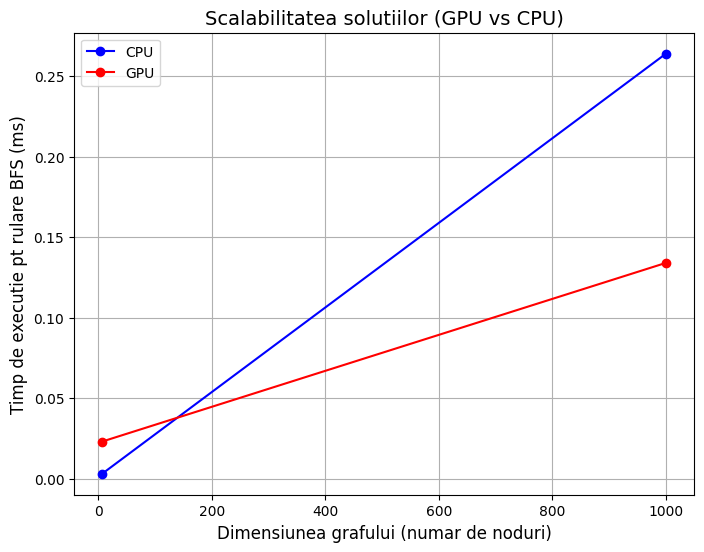

In [14]:
import matplotlib.pyplot as plt


nodes = [7, 1000]

cpu_times = [0.003, 0.264]
gpu_times = [0.023, 0.134]


plt.figure(figsize=(8,6))
plt.plot(nodes, cpu_times, label='CPU', marker='o', color='b')
plt.plot(nodes, gpu_times, label='GPU', marker='o', color='r')

plt.xlabel('Dimensiunea grafului (numar de noduri)', fontsize=12)
plt.ylabel('Timp de executie pt rulare BFS (ms)', fontsize=12)
plt.title('Scalabilitatea solutiilor (GPU vs CPU)', fontsize=14)


plt.legend()


plt.grid(True)
plt.show()
